In [1]:
# importing required pakages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import zscore
from optbinning import MulticlassOptimalBinning
from sklearn.preprocessing import  MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.svm import  SVC
from sklearn.linear_model import LogisticRegression
from scipy.stats import zscore
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import xgboost
from sklearn.ensemble import  RandomForestClassifier
from sklearn.ensemble.gradient_boosting import  GradientBoostingClassifier
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.ensemble import  AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
sb.set()

d:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.gradient_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
train = pd.read_excel('train_agriculture.xlsx')
test = pd.read_excel('test_agriculture.xlsx')

### EDA and Data-preprocessing

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4599 entries, 0 to 4598
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       4599 non-null   object 
 1   Estimated_Insects_Count  4599 non-null   int64  
 2   Crop_Type                4599 non-null   int64  
 3   Soil_Type                4599 non-null   int64  
 4   Pesticide_Use_Category   4599 non-null   int64  
 5   Number_Doses_Week        4599 non-null   int64  
 6   Number_Weeks_Used        4157 non-null   float64
 7   Number_Weeks_Quit        4599 non-null   int64  
 8   Season                   4599 non-null   int64  
 9   Crop_Damage              4599 non-null   int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 359.4+ KB


From above train dataset, we see that there are missing values in  column Number_Weeks_Used.

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199 entries, 0 to 1198
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       1199 non-null   object 
 1   Estimated_Insects_Count  1199 non-null   int64  
 2   Crop_Type                1199 non-null   int64  
 3   Soil_Type                1199 non-null   int64  
 4   Pesticide_Use_Category   1199 non-null   int64  
 5   Number_Doses_Week        1199 non-null   int64  
 6   Number_Weeks_Used        1080 non-null   float64
 7   Number_Weeks_Quit        1199 non-null   int64  
 8   Season                   1199 non-null   int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 84.4+ KB


From above test dataset, we see that there are missing values in  column Number_Weeks_Used.

In [5]:
# displaying unique values of each column.
for col in train.columns:
    print('no. of unique value in column ',col+': ' , len(train[col].unique()))

no. of unique value in column  ID:  4599
no. of unique value in column  Estimated_Insects_Count:  71
no. of unique value in column  Crop_Type:  2
no. of unique value in column  Soil_Type:  2
no. of unique value in column  Pesticide_Use_Category:  3
no. of unique value in column  Number_Doses_Week:  20
no. of unique value in column  Number_Weeks_Used:  64
no. of unique value in column  Number_Weeks_Quit:  47
no. of unique value in column  Season:  3
no. of unique value in column  Crop_Damage:  3


From above data, we can consider columns having unique values equal or less then 3 as categorical columns. 

In [6]:
# separating columns having unqiue values equal or less then 3 from other columns for separate analysis.
numeric_col = []
cat_col = []
for col in train.columns:
    if len(train[col].unique()) > 3:
        
           numeric_col.append(col)
    else:
           cat_col.append(col)

print('numeric columns: \n',numeric_col,'\n')
print('categorical columns: \n',cat_col)

numeric columns: 
 ['ID', 'Estimated_Insects_Count', 'Number_Doses_Week', 'Number_Weeks_Used', 'Number_Weeks_Quit'] 

categorical columns: 
 ['Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Season', 'Crop_Damage']


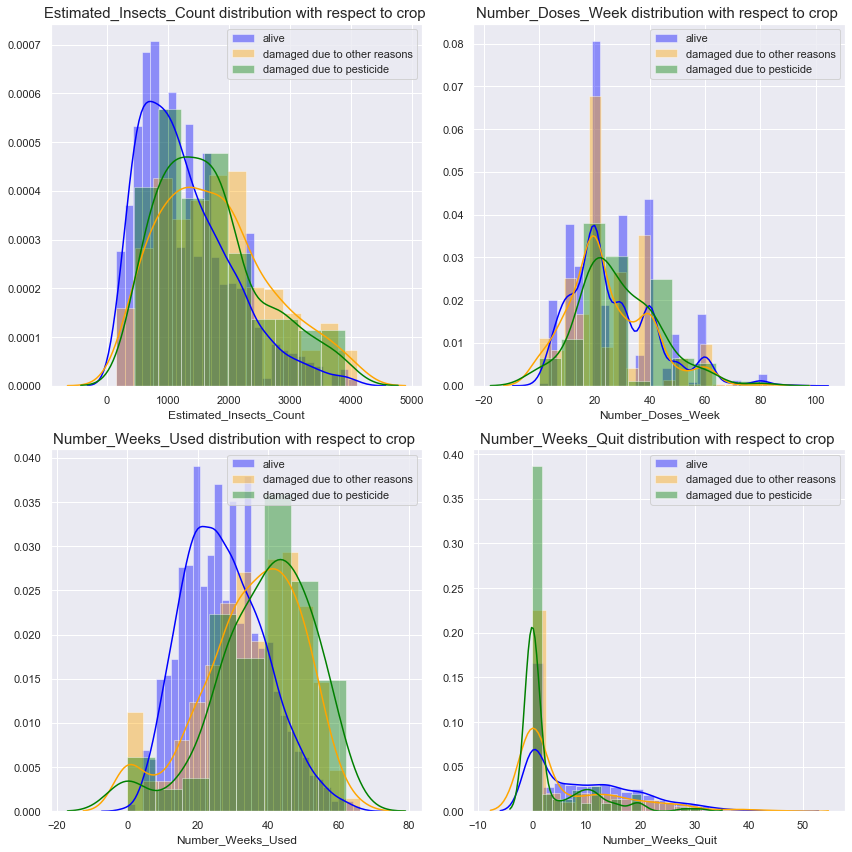

In [7]:
for i, col in enumerate(numeric_col[1:]):
    
    plt.subplot(2,2, i+1)

    sb.distplot(train[col][train['Crop_Damage'] == 0], color = 'blue')
    sb.distplot(train[col][train['Crop_Damage'] == 1], color = 'orange')
    sb.distplot(train[col][train['Crop_Damage'] == 2],  color = 'green')
    
    plt.legend(['alive','damaged due to other reasons','damaged due to pesticide'])

    plt.title(col+' distribution with respect to crop ', fontsize = 15)
    fig, ax = plt.gcf(), plt.gca()
    fig.set_size_inches(12,12)
    plt.tight_layout()
plt.show()

From above plots, we can see that Estimated Insects Count of around 1000 highly increases the chances of crop survival.

Number of Weeks used should be around 20 weeks for optimal condition for high survival probability of the crops.

And, optimum no. of doses per weeks should be around 20 doses for higher survival probability of the crops.

Also, we see for higher number of weeks quit, the survival probability decreases less then that of  other damaged conditions of crops.

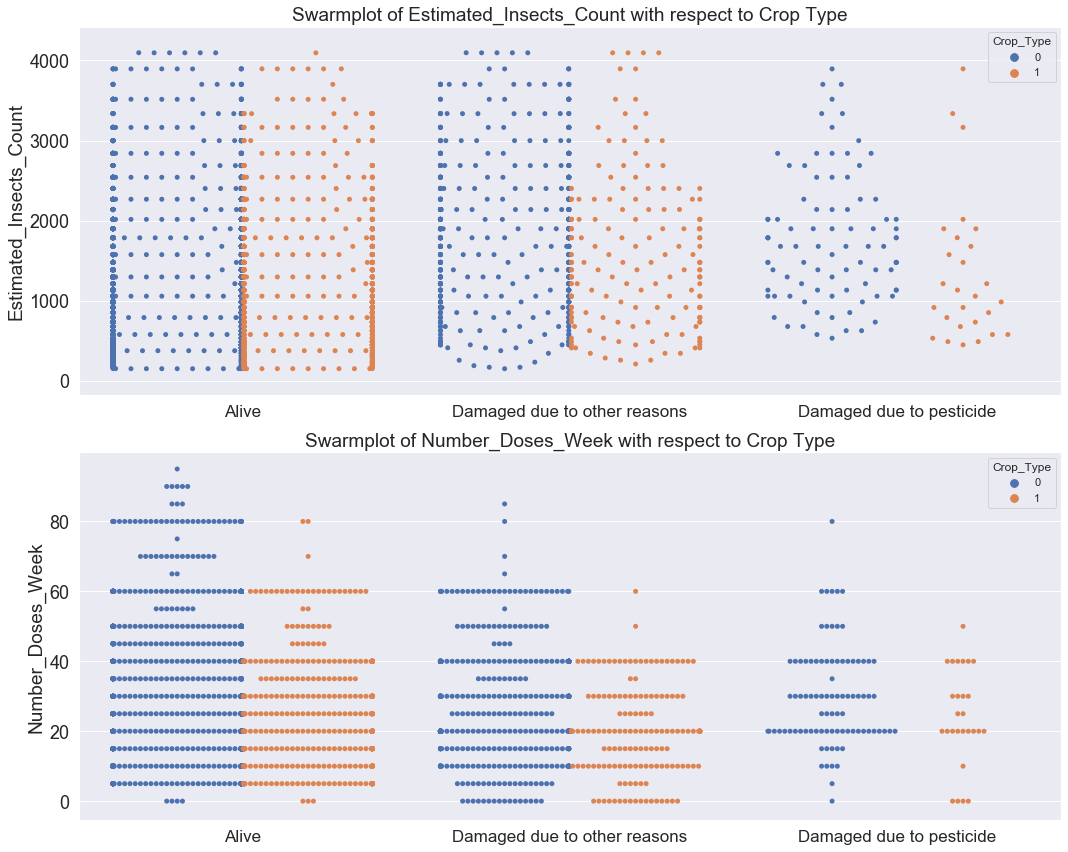

In [8]:
for i, col in enumerate(numeric_col[1:3]):
    
    plt.subplot(2,1, i+1)
    
    g = sb.swarmplot(x="Crop_Damage", y= col , data=train, hue = 'Crop_Type', dodge = True)
    
    g.set(xticklabels = ['Alive','Damaged due to other reasons','Damaged due to pesticide'])
    plt.title('Swarmplot of ' + col + ' with respect to Crop Type', fontsize = 19)
    fig, ax = plt.gcf(), plt.gca()
    plt.xticks(fontsize = 17)
    plt.yticks(fontsize = 18)
    plt.xlabel('')
    plt.ylabel(col,fontsize = 19)
    fig.set_size_inches(15,12)
    plt.tight_layout()
plt.show()

From above plot, we see that crop 0 ( for both damaged due to other reasons and pesticide) is more likely to increase with increase of estimated  insects count then the crop 1.

As for number of doses per week, we almost see similar trends, where crop 0 having larger spread in trend and therefore having larger range, mostly because the proportion of Crop 0 is greater then that of Crop 1.

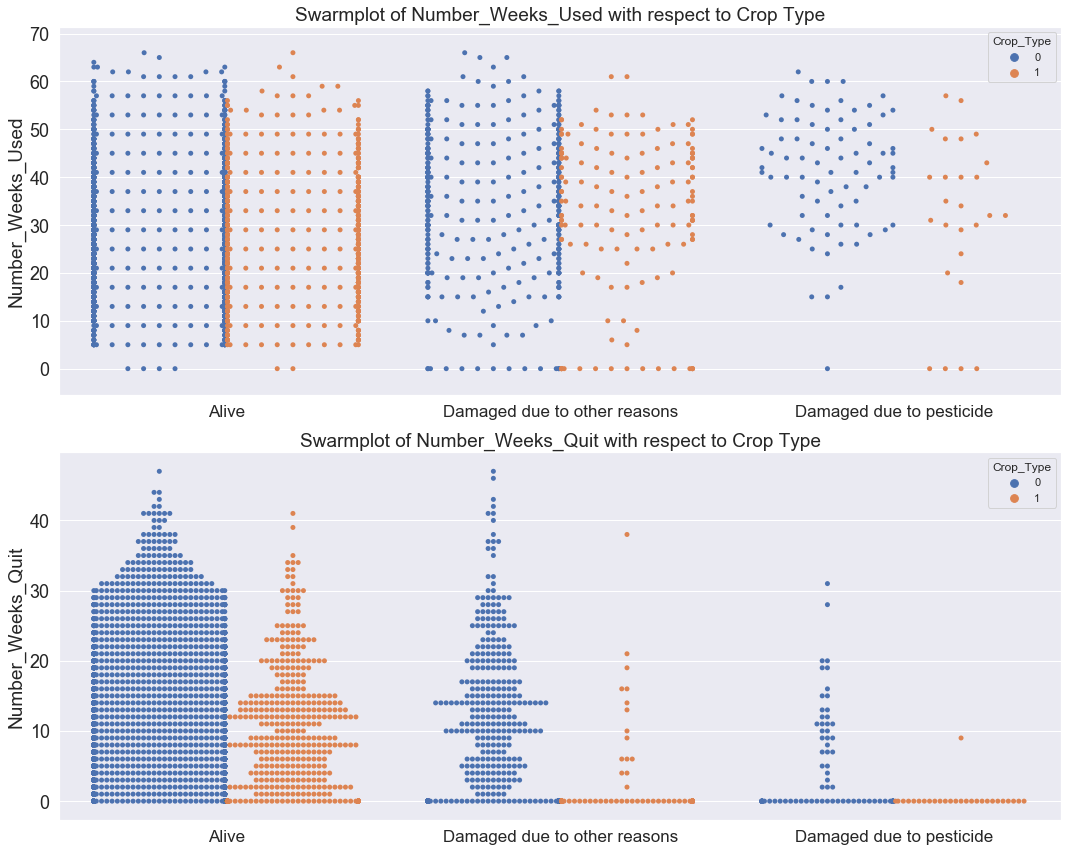

In [9]:
for i, col in enumerate(numeric_col[3:]):
    
    plt.subplot(2,1, i+1)
    
    g = sb.swarmplot(x="Crop_Damage", y= col , data=train, hue = 'Crop_Type',
                    dodge  = True)
    
    g.set(xticklabels = ['Alive','Damaged due to other reasons','Damaged due to pesticide'])
    plt.title('Swarmplot of ' + col + ' with respect to Crop Type', fontsize = 19)
    fig, ax = plt.gcf(), plt.gca()
    plt.xticks(fontsize = 17)
    plt.yticks(fontsize = 18)
    plt.xlabel('')
    plt.ylabel(col,fontsize = 19)
    fig.set_size_inches(15,12)
    plt.tight_layout()
plt.show()

From above plots,  we see that the crop 0 (for both damaged due to other reasons and pesticide) increases for higher values of no. of week used. 

We can also see that damaged crop 1 (both due to pesticide and other reasons) has almost no effect on increasing number of weeks quit. Having said that, this could may be due to lesser no. of crop 1 type in our data.

In [7]:
def bar_chart(feature):

    plt.figure(figsize = (10,6))
    g = sb.countplot(x= 'Crop_Damage' , hue = feature , data= train)
    g.set(xticklabels = ['Alive','Damaged due to other reasons','Damaged due to pesticide'])
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xlabel('')
    plt.ylabel('Crop count',fontsize = 14)
    plt.title('Crop Status due to different ' + feature, fontsize = 14)

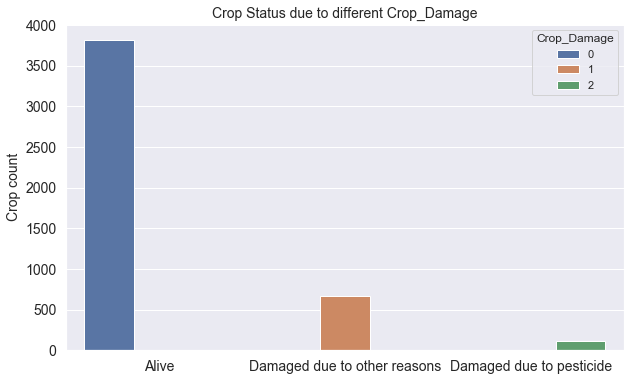

In [8]:
bar_chart('Crop_Damage')

From above plot, we see that, the counts of all categories are significantly different from each other, which implies heavy imbalanced class, so we shall choice metric like f1_macro in cross validation to address this problem. 

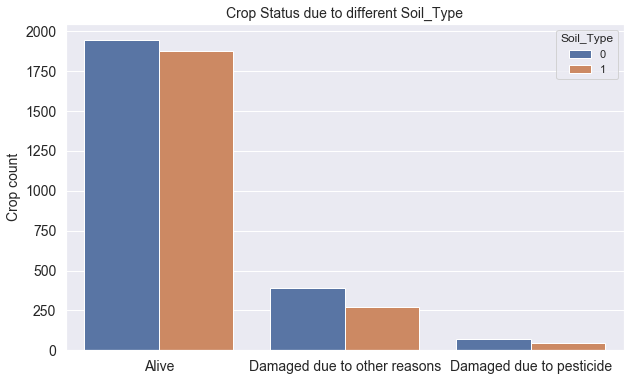

In [9]:
bar_chart('Soil_Type')

From above plots, we can infer that, the overall proportion of Soil type 0 is slightly greater, and having said that, the Soil type 0 appears to have higher vulnerability, interms of damage due to pesticide and other reasons.   

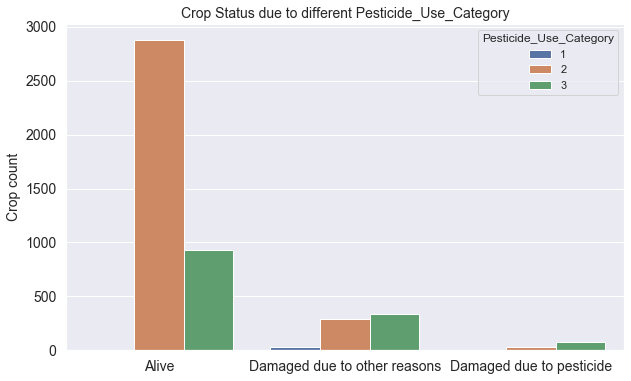

In [10]:
bar_chart('Pesticide_Use_Category')

From above plots, we can infer that, previously used pesticides (i.e. 2) are better option then  currently used pesticides (i.e. 3). 

Also, it is not advisable to not to use any pesticides(i.e. 1).

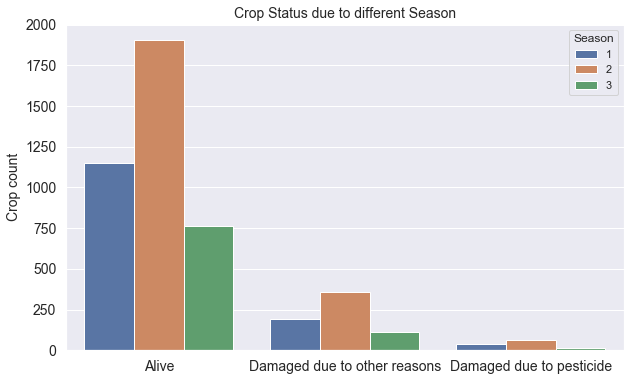

In [11]:
bar_chart('Season')

From above chart, provided that crops are not damaged by other factors, then season 2 is the most favourable for crop growth. 

Text(0.5, 1.0, 'Un-scaled numeric data')

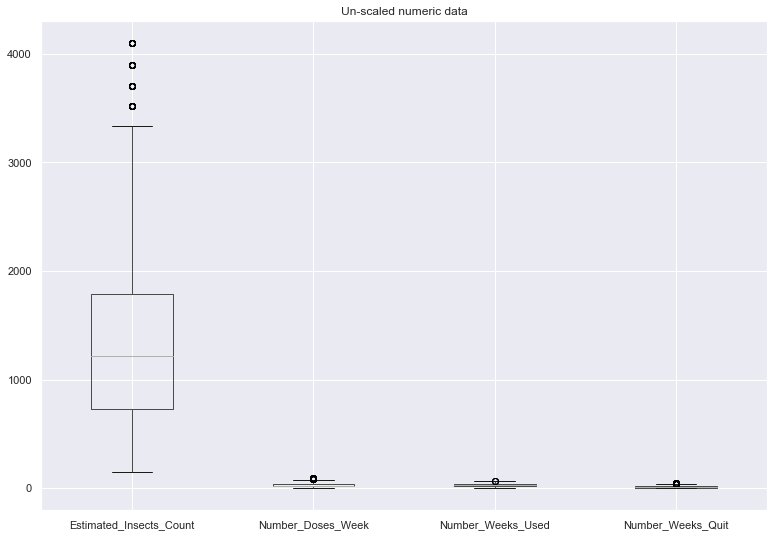

In [12]:
numeric_col.remove('ID')
train.boxplot(column = list(train[numeric_col].columns), figsize = (13,9))
plt.title('Un-scaled numeric data')

Here, we see numeric data are in different scale and also presence of outliers.

In [13]:
# imputing missing values in column Number_Weeks_Used.
train['Number_Weeks_Used'] = train.groupby(['Crop_Type','Soil_Type',
                'Season'])['Number_Weeks_Used'].transform(lambda x: x.fillna(x.median()))

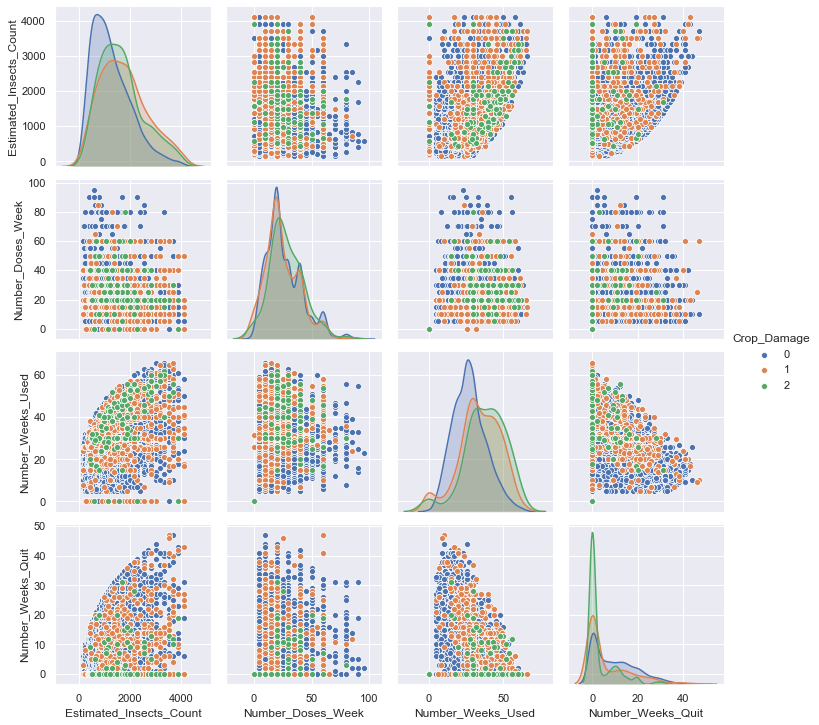

In [14]:
numeric_col.append('Crop_Damage')
sb.pairplot(train[numeric_col], hue = 'Crop_Damage')

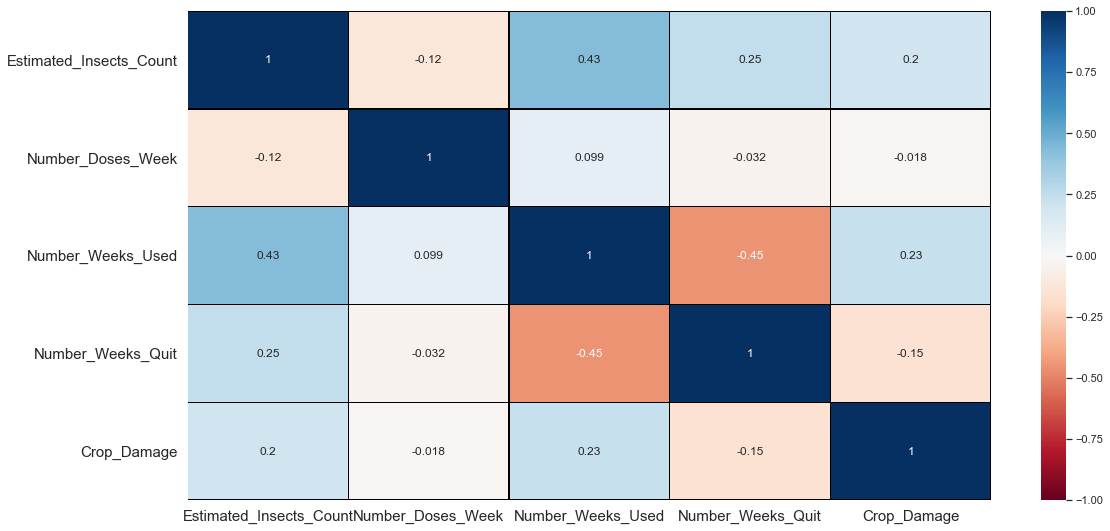

In [15]:
plt.figure(figsize = (18,9))
sb.heatmap(train[numeric_col].corr(), cmap = 'RdBu', vmin = -1, vmax = 1, center = 0, 
           linewidth = .5, linecolor = 'black', annot = True)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

Based on above pairplot and heatmap, we don't see much strong correlation between variables.

In [16]:
# splitting train dataset into x_train and x_test.
x_train, x_test, y_train, y_test = train_test_split(train.drop(['Crop_Damage','ID'],1), 
                                                     train.Crop_Damage ,
                                                     stratify = train.Crop_Damage,
                                                     random_state = 42,
                                                     test_size = 0.3)

In [17]:
cat_col.remove('Crop_Damage') # removing 'Crop_Damage' columns, as it is target variable.

In [18]:
x_train_copy = x_train.copy() # copying x_train for using later on.

In [19]:
x_train = pd.get_dummies(data = x_train, prefix = cat_col, columns = cat_col, drop_first = True  )
x_test = pd.get_dummies(data = x_test, prefix = cat_col, columns = cat_col, drop_first = True )

In [20]:
numeric_col.remove('Crop_Damage') # removing 'Crop_Damage' columns appended earlier, as it a target variable.

In [21]:
# supervised binning numerical columns using 'OptimalBinning' class.
for col in  numeric_col:
    
    optb = MulticlassOptimalBinning(name =  col, solver = 'mip', monotonic_trend = None)
    
    optb.fit(x_train[col].values, y_train)
    print('binning status for column ' + col+ ' is',optb.status,'\n')
    
    x_train[col] = optb.transform(x_train[col].values)
    x_test[col] = optb.transform(x_test[col].values)

binning status for column Estimated_Insects_Count is OPTIMAL 

binning status for column Number_Doses_Week is OPTIMAL 

binning status for column Number_Weeks_Used is OPTIMAL 

binning status for column Number_Weeks_Quit is OPTIMAL 



Here, we are binning the numeric variables based on weight of evidence (WOE). Also, by doing so, we don't have to bother about skewed distribution of data and  presence of outliers.

In [22]:
s = StratifiedKFold(n_splits = 10)

### Base Model Evaluation

model: RandomForestClassifier()
CV score:0.3967416665009226
score_std: 0.05051058089561411
----------
model: LogisticRegression()
CV score:0.3694845154341847
score_std: 0.018986145710706226
----------
model: SVC()
CV score:0.3330784083158671
score_std: 0.01186751889440606
----------
model: AdaBoostClassifier()
CV score:0.33598133119722595
score_std: 0.012986554221689225
----------
model: GradientBoostingClassifier()
CV score:0.38941961194051156
score_std: 0.03841861826760363
----------
model: KNeighborsClassifier()
CV score:0.3560503458116887
score_std: 0.020705679487002415
----------
model: XGBClassifier(silent=True)
CV score:0.35888402251027257
score_std: 0.016159806240851293
----------
model: DecisionTreeClassifier()
CV score:0.3768198222697974
score_std: 0.041420890907837564
----------
model: GaussianNB()
CV score:0.4476162540204843
score_std: 0.04217690111118124
----------


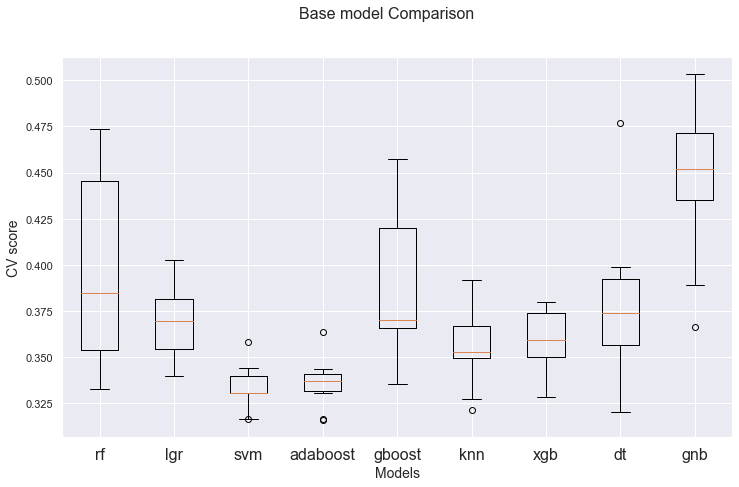

In [23]:
rf = RandomForestClassifier()
svm = SVC()
lgr = LogisticRegression()
adaboost =  AdaBoostClassifier()
gboost = GradientBoostingClassifier()
knn = KNeighborsClassifier()
xgb = xgboost.XGBClassifier(silent = True)
dt = DecisionTreeClassifier()
gnb = GaussianNB()


models = [rf, lgr, svm, adaboost, gboost, knn, xgb, dt, gnb]

scores = []
for model in models:
    
    score = cross_val_score(model, x_train, y_train, cv = s, scoring = 'f1_macro', n_jobs = -1 )
    mean_score = score.mean()
    std_score = score.std()
    
    print('model: {}'.format(model))
    print('CV score:{}'.format(mean_score))
    print('score_std:',std_score)
    print('----------')
    scores.append(score)
    
fig = plt.figure()
fig.suptitle('Base model Comparison', fontsize = 16)
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(['rf', 'lgr','svm', 'adaboost', 'gboost', 'knn', 'xgb','dt','gnb'],
                  fontsize = 16)
plt.xlabel('Models', fontsize = 14)
plt.ylabel('CV score', fontsize = 14)
fig.set_size_inches(12,7)
plt.show() 

From above cross-val-scores, we shall choose  models rf, lgr, knn, gboost, dt and gnb, and this selection is based on mean and median scores.

### Hyper-parameter tuning

In [24]:
param_gboost =  dict(
   learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.5, 0.6 ],
   max_depth = [ 2, 3, 4, 5, 6, 8, 10, 12, 15],
   n_estimators = [30 ,50,75,100, 150, 200],
   min_samples_split = [1,2,3],
   min_samples_leaf = [1,2], random_state = [41,42,43])


param_lgr = dict(penalty = ['l1','l2'],  C = np.logspace(4,-4,60), 
                 solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                 max_iter = [100,150,200,250,300])

param_rf = dict(n_estimators = [10,15,20,25,30], criterion = ['gini', 'entropy'],
                max_depth = [3,4,5,6,7,8,None],min_samples_split = [2,3,4],
                min_samples_leaf = [1,2,3], random_state = [41,42,43])
param_knn = dict(n_neighbors = np.arange(1,30,1), algorithm = ['auto','ball_tree','kd_tree','brute'],
                leaf_size = [25,30,35], p = [1,2], weights = ['uniform','distance'])\

param_dt = dict(criterion = ['gini', 'entropy'], splitter = ['best', 'random'],
               min_samples_split = [1,2,3,4], min_samples_leaf = [1,2,3],
               max_features = ['auto', 'sqrt', 'log2'], random_state = [41,42,43],
               class_weight = ['balanced'])

In [25]:
model_param_list = [( gboost,param_gboost),(lgr,param_lgr),
                   (dt, param_dt),(rf,param_rf), (knn, param_knn)]

In [26]:
%%time
best_estimator_list = []
for model, param in model_param_list:
    
    r_search = RandomizedSearchCV(model, param, cv = s, n_jobs = -1, scoring = 'f1_macro',
                                  random_state = 42)
    r_search.fit( x_train, y_train.values.ravel())
    best_cvscore = r_search.best_score_
    best_param = r_search.best_params_
    best_estimator = r_search.best_estimator_
    best_estimator_list.append(best_estimator)
    
    print('model:',model)
    print('best_cvscore:',best_cvscore)
    print('best_param:', best_param)
    print('\n')
    
print('best_estimators:',best_estimator_list)

model: GradientBoostingClassifier()
best_cvscore: 0.4231533231366722
best_param: {'random_state': 41, 'n_estimators': 75, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 5, 'learning_rate': 0.3}


model: LogisticRegression()
best_cvscore: 0.37213214437398845
best_param: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 150, 'C': 602.0894493336125}


model: DecisionTreeClassifier()
best_cvscore: 0.38848271841166715
best_param: {'splitter': 'best', 'random_state': 43, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'criterion': 'gini', 'class_weight': 'balanced'}


model: RandomForestClassifier()
best_cvscore: 0.3703485789627574
best_param: {'random_state': 43, 'n_estimators': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'gini'}


model: KNeighborsClassifier()
best_cvscore: 0.397044970507635
best_param: {'weights': 'distance', 'p': 2, 'n_neighbors': 13, 'leaf_size': 25, 'algorithm': 'brute'}


best_estimators: [Gradi

### Testing

In [27]:
best_estimator_list.append(gnb) # appending GaussianNB  for testing.

In [28]:
print('*******TRAIN RESULTS*******')
print('\n')

for model in best_estimator_list:
    model.fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_train)
    score = accuracy_score(y_train, y_pred)
    print('model',model,'\n')
    print('accuracy:',round(score*100,2),'%','\n')
    print('f1_score (macro):',round(f1_score(y_train,y_pred, average = 'macro')*100,2),'%','\n')
    print('Classification report:','\n', classification_report(y_train, y_pred))
    print('------------------------------------------------------------------------------')
    print('\n')

*******TRAIN RESULTS*******


model GradientBoostingClassifier(learning_rate=0.3, max_depth=5, min_samples_split=3,
                           n_estimators=75, random_state=41) 

accuracy: 93.13 % 

f1_score (macro): 85.41 % 

Classification report: 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      2674
           1       0.92      0.61      0.73       465
           2       0.92      0.82      0.87        80

    accuracy                           0.93      3219
   macro avg       0.92      0.81      0.85      3219
weighted avg       0.93      0.93      0.93      3219

------------------------------------------------------------------------------


model LogisticRegression(C=602.0894493336125, max_iter=150) 

accuracy: 83.78 % 

f1_score (macro): 37.42 % 

Classification report: 
               precision    recall  f1-score   support

           0       0.85      0.99      0.91      2674
           1       0.53      0.13      0.2

In [29]:
print('*******TEST RESULTS********')
print('\n')

for model in best_estimator_list:
    model.fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_test)
    score = accuracy_score(y_test, y_pred)
    
    print('Model:',model,'\n')
    print('accuracy:',round(score*100,2),'%','\n')
    print('f1_score (macro):',round(f1_score(y_test,y_pred, average = 'macro')*100,2),'%','\n')
    print('Classification report:','\n', classification_report(y_test, y_pred))
    print('------------------------------------------------------------------------------')
    print('\n') 

*******TEST RESULTS********


Model: GradientBoostingClassifier(learning_rate=0.3, max_depth=5, min_samples_split=3,
                           n_estimators=75, random_state=41) 

accuracy: 82.25 % 

f1_score (macro): 40.01 % 

Classification report: 
               precision    recall  f1-score   support

           0       0.86      0.95      0.90      1146
           1       0.45      0.22      0.30       199
           2       0.00      0.00      0.00        35

    accuracy                           0.82      1380
   macro avg       0.44      0.39      0.40      1380
weighted avg       0.78      0.82      0.79      1380

------------------------------------------------------------------------------


Model: LogisticRegression(C=602.0894493336125, max_iter=150) 

accuracy: 83.91 % 

f1_score (macro): 36.87 % 

Classification report: 
               precision    recall  f1-score   support

           0       0.85      0.99      0.91      1146
           1       0.59      0.12      0

From above train and test results, we can see that from classification report, GaussianNB is the only model, that performed better then the rest in classifying both the minor classes - class 2 (i.e. damaged due to pesticide) and class 1 (i.e. damaged due to other reasons), which is based on f1_scores of these classes. Also, it has highest f1_score (macro) of 40.6 % compared to other models.

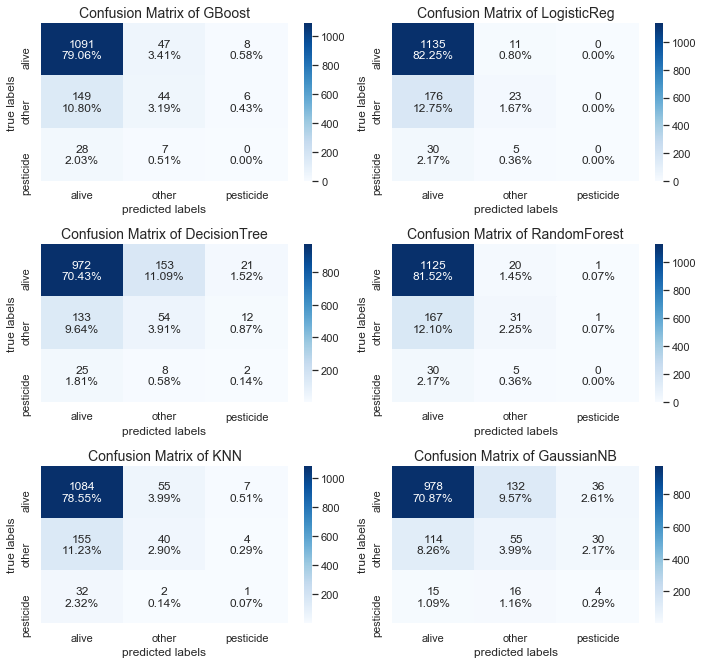

In [30]:
# visualizing confusion matrix  with the help of heatmaps.
model_index = [0,1,2,3,4,5]
model = ['GBoost','LogisticReg','DecisionTree','RandomForest','KNN','GaussianNB']

for index ,model, model_name in zip(model_index,best_estimator_list,model):
    plt.subplot(4,2, index + 1 )
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    c_matric = confusion_matrix(y_test, y_pred)

    group_counts = ['{0:0.0f}'.format(value) for value in
                c_matric.flatten()]
    group_percent = ['{0:.2%}'.format(value) for value in
                     c_matric.flatten()/np.sum(c_matric)]
    labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_counts,group_percent)]
    labels = np.asarray(labels).reshape(3,3)
    sb.heatmap(c_matric, annot=labels, fmt='', cmap='Blues')
    plt.title('Confusion Matrix of ' + model_name, fontsize = 14)
    
    plt.ylabel('true labels')
    plt.xlabel('predicted labels')
    fig, ax = plt.gcf(), plt.gca()
    ax.set_xticklabels(['alive','other','pesticide'])
    ax.set_yticklabels(['alive','other','pesticide'])
    fig.set_size_inches(10, 12)
    plt.tight_layout()
plt.show()

By analysing above heatmaps, we see that GaussianNB model performed better then the rest in classifying the minor class (i.e damaged due to pesticide), which is the only controllable factor in reducing the number of damaged crops. Moreover, it fairly classified the damaged crops (i.e. damaged due to other reasons) as well.

Also, it is worth noting that, even though applying metrics like f1_macro, since due to heavy imbalanced dataset, we are not able to get the optimum performance for classifying the minor class from the algorithm used. Having said that, there can be other techniques to apply for data imbalance like- undersampling, oversampling and even we can try to generate synthetic samples, however, these are techniques that have not been implemented in this project, but can be definitely implemented for better performance on minor classes.

Thus, based on the number of correctly classified minor classes, we can select GaussianNB as our classifier in this project. 

In [31]:
# selecting the best performing model.
selected_model = GaussianNB() 

selected_model.fit(x_train, y_train)
y_pred = selected_model.predict(x_test)

In [32]:
test_1 = pd.DataFrame({'Actual crop status':y_test.values,'Actual crop status':y_pred})

In [33]:
test_1.to_csv('crop_status_pred.csv', index = False)
print('Predicted result stored sucessfully.')

Predicted result stored sucessfully.


In [34]:
# Saving the final model as GaussianNB.
import joblib

joblib.dump(selected_model, 'crop_status_pred.obj')
print('Model successfully saved.')

Model successfully saved.


#### Data-preprocessing of test dataset

In [35]:
# imputing missing values in test dataset
test['Number_Weeks_Used'] = test.groupby(['Crop_Type','Soil_Type',
                'Season'])['Number_Weeks_Used'].transform(lambda x: x.fillna(x.median()))


# dummy encoding categorical variables in test-dataset.
test = pd.get_dummies(data = test, prefix = cat_col, columns = cat_col, drop_first = True)
test.drop('ID',1,inplace = True) 
test_trans = test.copy()

# supervised binning numeric variables in test dataset, based on fitted data of x_train_copy.
for col in  numeric_col:
    optb = MulticlassOptimalBinning(name =  col, solver = 'mip', monotonic_trend = None)
    
    optb.fit(x_train_copy[col].values, y_train)
    test_trans[col] = optb.transform(test_trans[col].values , metric='weighted_mean_woe')

In [36]:
# loading  object file of the model for predicting test dataset.
model = joblib.load('crop_status_pred.obj')

In [37]:
y_test_pred = model.predict(test_trans)

In [38]:
test_2 = pd.DataFrame({'Pedicted crop status':y_test_pred})

In [39]:
test_2.to_csv('crop_status__test_pred.csv', index = False)
print('Predicted result of test data  stored sucessfully.')

Predicted result of test data  stored sucessfully.
